# Import data and libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from scipy.stats import dirichlet


pima_names = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age', 'Class']
pima = pd.read_table('pima/pima.txt', sep = ",", names=pima_names)
pima.reindex(index=pima_names)
print(pima.head())

   Number of times pregnant  Plasma glucose  Diastolic blood pressure  \
0                         6             148                        72   
1                         1              85                        66   
2                         8             183                        64   
3                         1              89                        66   
4                         0             137                        40   

   Triceps skin fold thickness  2-Hour serum insulin  Body mass index   \
0                           35                     0              33.6   
1                           29                     0              26.6   
2                            0                     0              23.3   
3                           23                    94              28.1   
4                           35                   168              43.1   

   Diabetes pedigree function  Age  Class  
0                       0.627   50      1  
1                       0.35

In [21]:
pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age', 'Class']]

,Number of times pregnant,Plasma glucose,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 檢查是否有Categorical資料與缺失值

In [22]:
# find categorical variables

categorical = [var for var in pima.columns if pima[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

# view the categorical variables if they exist

pima[categorical].head()

There are 0 categorical variables

The categorical variables are :

 []


""
0
1
2
3
4


In [23]:
# 檢查categorical attribute中是否有missing values

pima[categorical].isnull().sum()

Series([], dtype: float64)

In [24]:
# 計算各個 class 的個數
freq = pima['Class'].value_counts()
print(freq)

0    500
1    268
Name: Class, dtype: int64


# Data Preprocessing

## Ten-bin discretization

In [50]:
scoring = 'accuracy'

In [51]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

In [52]:
print(X_t[0])

[3. 7. 5. 3. 0. 5. 2. 4.]


In [53]:
print(np.shape(X_t))

(768, 8)


#  Model 1 : Naive Bayesian classifier have Dirichlet priors with the Laplace’s estimate

In [54]:
import scipy.stats
# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

[[0.67560069 0.32439931]]


MultinomialNB(alpha=1, class_prior=array([0.67560069, 0.32439931]))

## 5-Fold cross validation

In [55]:
score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

Means of 5-Fold cross validation: 0.655


## Ranking Attribute by selective naïve Bayes

In [56]:
result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

[ 0.01302083  0.00286458 -0.00260417 -0.00260417  0.00546875 -0.0046875
  0.00520833  0.02005208]


In [57]:
importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])

0.02005208333333337
0.01302083333333337
0.005468750000000045
0.00520833333333337
0.0028645833333333704
-0.0026041666666666297
-0.0026041666666666297
-0.0046875


<function matplotlib.pyplot.show(close=None, block=None)>

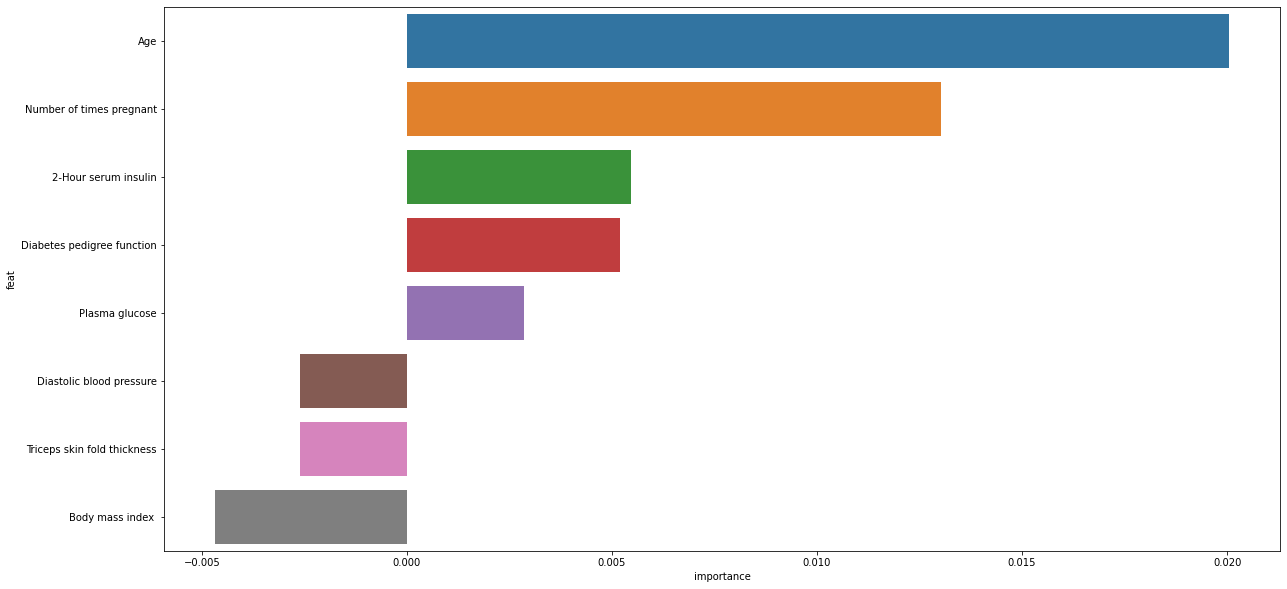

In [58]:
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

## 重新排序特徵

In [59]:
X = pima[['Number of times pregnant', 'Plasma glucose', 
              '2-Hour serum insulin','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.646


## 額外實驗：個別刪除特徵

### 個別刪除 Body mass index

In [61]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.655


### 個別刪除 Diastolic blood pressure

In [62]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.659


### 個別刪除 Triceps skin fold thickness

In [64]:

X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure',
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.651


### 只刪除 Body mass index 與 Diastolic blood pressure

In [65]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Triceps skin fold thickness', 
              '2-Hour serum insulin','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.642


### 只刪除 Body mass index 與 Triceps skin fold thickness

In [66]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure',
              '2-Hour serum insulin','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.654


### 只刪除Diastolic blood pressure 與 Triceps skin fold thickness

In [67]:
X = pima[['Number of times pregnant', 'Plasma glucose', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring='accuracy', cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.652


## 額外實驗：更換評估函數

### 更換成F1 Score

In [70]:
scoring = 'f1'

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.388
[ 7.23106661e-02  1.27464312e-02 -1.64934298e-02 -1.54365525e-04
 -4.26675968e-03 -7.24347829e-03  7.81765513e-05  8.07178209e-02]
0.08071782091427357
0.07231066614057358
0.012746431239421652
7.817655125286205e-05
-0.00015436552510685874
-0.0042667596816817754
-0.007243478288027849
-0.01649342979090541


<function matplotlib.pyplot.show(close=None, block=None)>

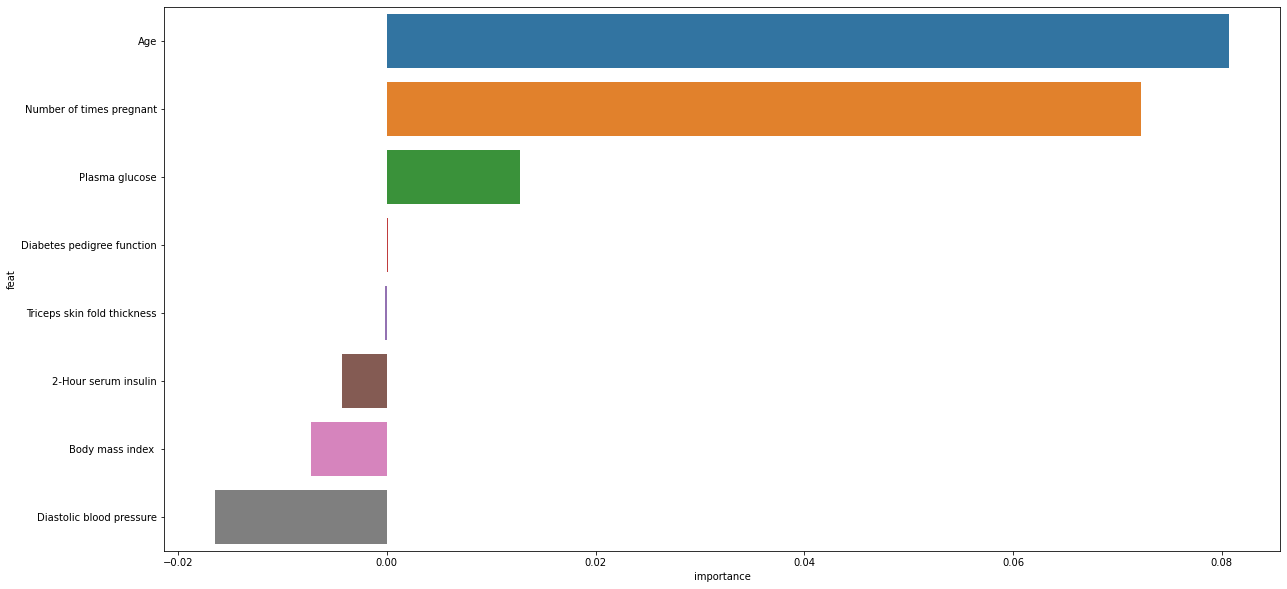

In [71]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)


score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))


result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])
    
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### 刪除F1 Score所算出來的重要性負數之特徵

In [76]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.341


### 更換成 Precision

In [77]:
scoring = 'precision'

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.508
[ 0.03022747  0.00576834 -0.00423048 -0.00701764  0.01396072 -0.01126143
  0.01356897  0.05035041]
0.05035040736084867
0.030227467361800466
0.013960723167456623
0.013568969296357536
0.005768341408733391
-0.0042304846873015165
-0.0070176440304552615
-0.011261432638184554


<function matplotlib.pyplot.show(close=None, block=None)>

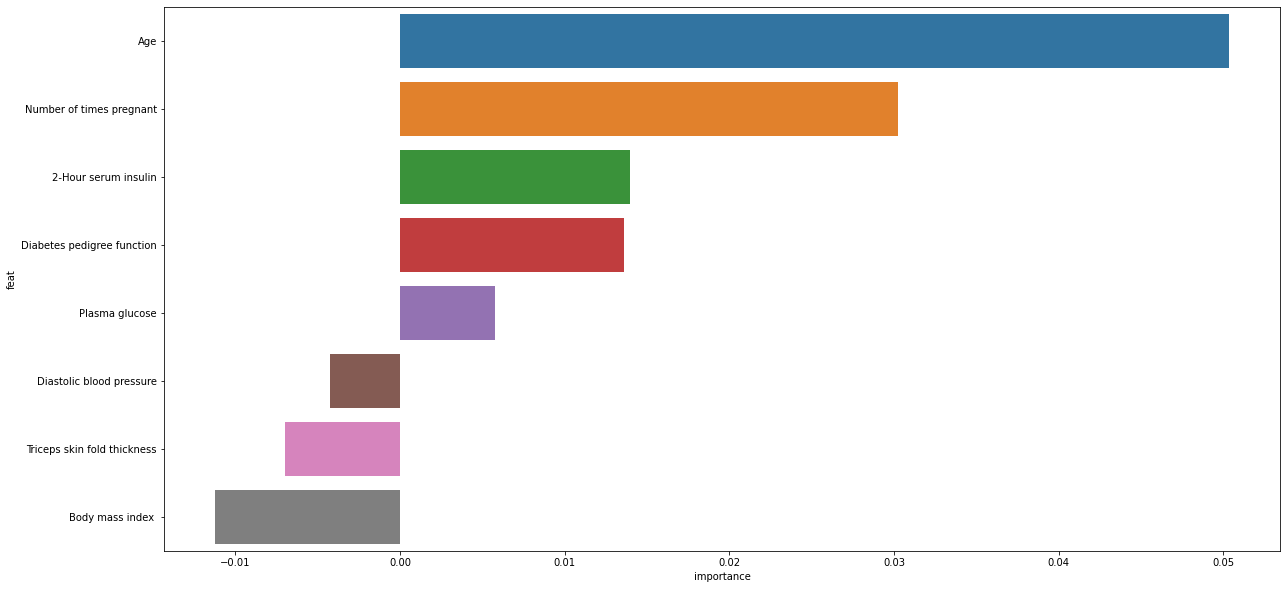

In [78]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)


score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))


result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])
    
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### 刪除 Precision 所算出來的重要性負數之特徵

In [84]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.506


### 更換成 Recall

In [87]:
scoring = 'recall'

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.317
[ 0.07761194  0.0141791  -0.02014925  0.00223881 -0.01119403 -0.00522388
 -0.00522388  0.08208955]
0.08208955223880596
0.07761194029850746
0.014179104477611925
0.002238805970149249
-0.005223880597014929
-0.005223880597014929
-0.011194029850746278
-0.020149253731343287


<function matplotlib.pyplot.show(close=None, block=None)>

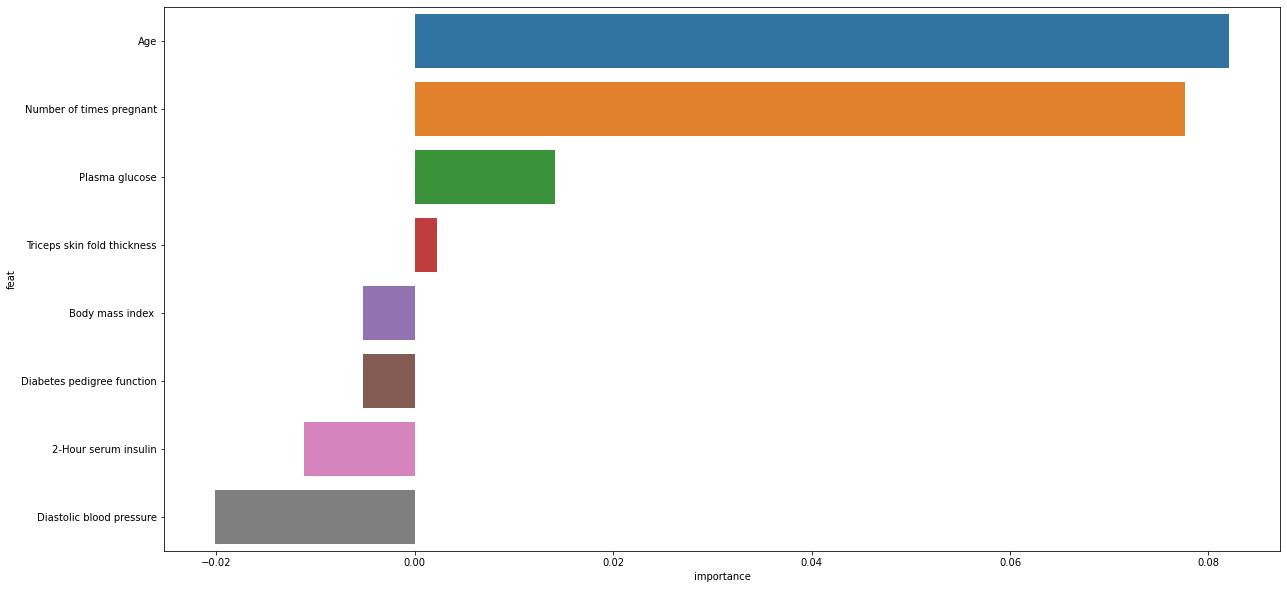

In [88]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# 對 id 和 class 以外的特徵做 ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)


score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))


result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大到排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])
    
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

### 刪除 Precision 所算出來的重要性負數之特徵

In [92]:
X = pima[ ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [500, 268], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.67560069 0.32439931]]
Means of 5-Fold cross validation: 0.34


#  Model 2 : Naive Bayesian classifier have  the best noninformative Dirichlet priors

In [100]:
scoring = 'accuracy'

[[0.29751149 0.70248851]]
Means of 5-Fold cross validation: 0.487
[ 0.03489583  0.0125     -0.01953125 -0.00286458  0.01145833 -0.01536458
  0.02265625  0.05494792]
0.05494791666666665
0.03489583333333331
0.02265625
0.012499999999999989
0.011458333333333326
-0.0028645833333333704
-0.015364583333333359
-0.01953125000000001


<function matplotlib.pyplot.show(close=None, block=None)>

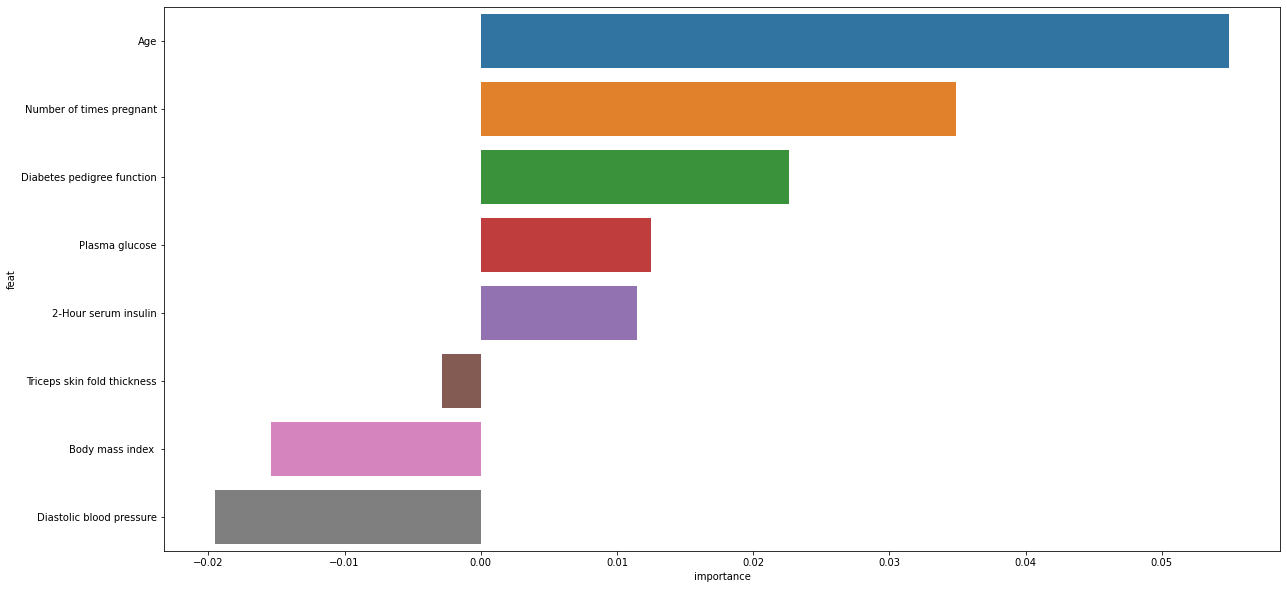

In [101]:
X = pima[['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']


est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量，這邊把alpha都換成了1
d = scipy.stats.dirichlet.rvs(alpha = [1,1], size=1, random_state=1)
print(d)

clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)


score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

result = permutation_importance(clf, X_t, y,scoring=scoring, random_state=0)

print(result.importances_mean)

importances = result.importances_mean

# 把 Attribute 的重要性由大排序輸出
indices = np.argsort(importances)[::-1]

for i in range(X.shape[1]):
    print('%-10s'%result.importances_mean[indices[i]])
    
# 視覺化
import seaborn as sns
featImp = pd.DataFrame()
featImp['feat'] = ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20], orient='h')
plt.show

## 重新排序特徵

In [111]:
X = pima[ ['Number of times pregnant', 'Plasma glucose', 'Diastolic blood pressure',
              '2-Hour serum insulin', 'Body mass index ','Diabetes pedigree function', 'Age']]
y = pima['Class']

# print(X.head())

# Ten-bin
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_t = est.fit_transform(X)

# alpha 是各個 class 的數量
d = scipy.stats.dirichlet.rvs(alpha = [1,1], size=1, random_state=1)
print(d)

# alpha=1 代表 Laplace’s estimate 的分子是 n_ij + 1
clf = MultinomialNB(alpha=1, fit_prior = True, class_prior=d.flatten())
clf.fit(X_t, y)

score = cross_val_score(clf, X_t, y, scoring=scoring, cv=5)
print('Means of 5-Fold cross validation:', round(score.mean(),3))

[[0.29751149 0.70248851]]
Means of 5-Fold cross validation: 0.478
